### Flatness v.s. Generalizatio

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import copy
from torchsummary import summary
from sklearn.decomposition import PCA 
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    print("CUDA is available. You can run your code on GPU!")
else:
    print("CUDA is not available. Running on CPU instead.")

CUDA is available. You can run your code on GPU!


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
batch_size = 64

trainset = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = torchvision.datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(testset ,batch_size = batch_size, shuffle=True)

In [5]:
batch_size = 1024

trainset2 = torchvision.datasets.MNIST('data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
train_loader2 = torch.utils.data.DataLoader(trainset2, batch_size = batch_size, shuffle=True)

testset2 = torchvision.datasets.MNIST('data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
test_loader2 = torch.utils.data.DataLoader(testset2 ,batch_size = batch_size, shuffle=True)

In [6]:
class Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.fcy1 = nn.Linear(784, 64)
        self.fcy2 = nn.Linear(64, 16)
        self.fcy3 = nn.Linear(16, 10)

    def forward(self, x):
        x = nn.functional.relu(self.fcy1(x))
        x = nn.functional.relu(self.fcy2(x))
        x = self.fcy3(x)
        return x

model_batch1 = Model()
model_batch2 = Model()
model_lr1 = Model()
model_lr2 = Model()

In [7]:
def interpolate_models(model_A, model_B, alpha):
    interpolated_model = Model().to(device)
    # set weights
    for p in interpolated_model.state_dict():
        p_a = model_A.state_dict()[p].cpu().numpy()
        p_b = model_B.state_dict()[p].cpu().numpy()
        interpolated_model.state_dict()[p][:] = torch.Tensor((1-alpha)*p_a + alpha*p_b)
    
    return interpolated_model.to(device)

In [8]:
def evaluate_test_loss(dataloader, model): 
    loss_fn = nn.CrossEntropyLoss()
    
    model.eval()
    
    # train and store epoch training loss
    epoch_test_loss = 0.0
    for batch, (X_test, y_test) in enumerate(dataloader): 
        X_test = X_test.to(device).reshape(-1, 28*28)
        y_test = y_test.to(device)

        # compute model predictions and loss
        y_pred = model(X_test)
        loss = loss_fn(y_pred, y_test)

        # update epoch loss with batch loss (epoch loss := mean batch loss throughout all batches)
        epoch_test_loss += loss.item() / len(dataloader)
    
    # return epoch loss
    return epoch_test_loss

In [9]:
def params_count(model):
    return sum(params.numel() for params in model.parameters() if params.requires_grad)

def test_test_data(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images, labels = images.to(device).reshape(-1, 28*28), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data,dim=1)      
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            
    return correct/total

def test_train_data(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            images,labels = data
            images, labels = images.to(device).reshape(-1, 28*28), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data,dim=1)      
            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            
    return correct/total

In [10]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batch1.parameters(), lr = 1e-3)

for epoch in range(num_epochs):

    loss_per_epoch = 0
    model_batch1 = model_batch1.to(device)
    model_batch1.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device).reshape(-1, 28*28)
        labels = labels.to(device)

        # forward pass
        outputs = model_batch1(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_batch2.parameters(), lr = 1e-3)

for epoch in range(num_epochs):

    loss_per_epoch = 0
    model_batch2 = model_batch2.to(device)
    model_batch2.train()

    for i, (images, labels) in enumerate(train_loader2):
        images = images.to(device).reshape(-1, 28*28)
        labels = labels.to(device)

        # forward pass
        outputs = model_batch2(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [12]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lr1.parameters(), lr = 1e-3)

for epoch in range(num_epochs):

    loss_per_epoch = 0
    model_lr1 = model_lr1.to(device)
    model_lr1.train()

    for i, (images, labels) in enumerate(train_loader2):
        images = images.to(device).reshape(-1, 28*28)
        labels = labels.to(device)

        # forward pass
        outputs = model_lr1(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [13]:
num_epochs = 40

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_lr2.parameters(), lr = 1e-2)

for epoch in range(num_epochs):

    loss_per_epoch = 0
    model_lr2 = model_lr2.to(device)
    model_lr2.train()

    for i, (images, labels) in enumerate(train_loader2):
        images = images.to(device).reshape(-1, 28*28)
        labels = labels.to(device)

        # forward pass
        outputs = model_lr2(images)
        loss = criterion(outputs, labels)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
train_loss_list_alpha_batch = []
test_loss_list_alpha_batch = []
train_acc_list_alpha_batch = []
test_acc_list_alpha_batch = []

train_loss_list_alpha_lr = []
test_loss_list_alpha_lr = []
train_acc_list_alpha_lr = []
test_acc_list_alpha_lr = []

In [15]:
alpha_list = np.linspace(-1, 2,40)
for alpha in alpha_list:
    model_alpha_batch = interpolate_models(model_batch1, model_batch2, alpha)
    model_alpha_lr = interpolate_models(model_lr1, model_lr2, alpha)
    
    train_loss_list_alpha_batch.append(evaluate_test_loss(train_loader, model_alpha_batch))
    test_loss_list_alpha_batch.append(evaluate_test_loss(test_loader, model_alpha_batch))
    train_acc_list_alpha_batch.append(test_train_data(model_alpha_batch))
    test_acc_list_alpha_batch.append(test_test_data(model_alpha_batch))
    
    train_loss_list_alpha_lr.append(evaluate_test_loss(train_loader, model_alpha_lr))
    test_loss_list_alpha_lr.append(evaluate_test_loss(test_loader, model_alpha_lr))
    train_acc_list_alpha_lr.append(test_train_data(model_alpha_lr))
    test_acc_list_alpha_lr.append(test_test_data(model_alpha_lr))

In [16]:
model_alpha_batch = interpolate_models(model_batch1, model_batch2, 2)
test_test_data(model_alpha_batch)

0.2177

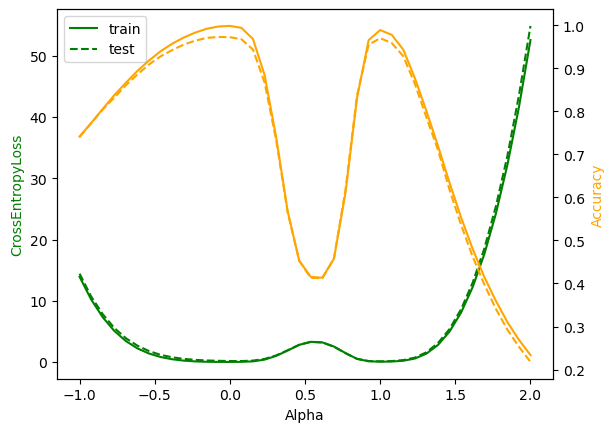

In [27]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Alpha')
ax1.set_ylabel('CrossEntropyLoss', color='green')
ax1.plot(alpha_list, train_loss_list_alpha_batch, color='green', label="train")
ax1.plot(alpha_list, test_loss_list_alpha_batch, '--', color='green', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='orange')
ax2.plot(alpha_list, train_acc_list_alpha_batch, color='orange')
ax2.plot(alpha_list, test_acc_list_alpha_batch, '--', color='orange')

plt.show()

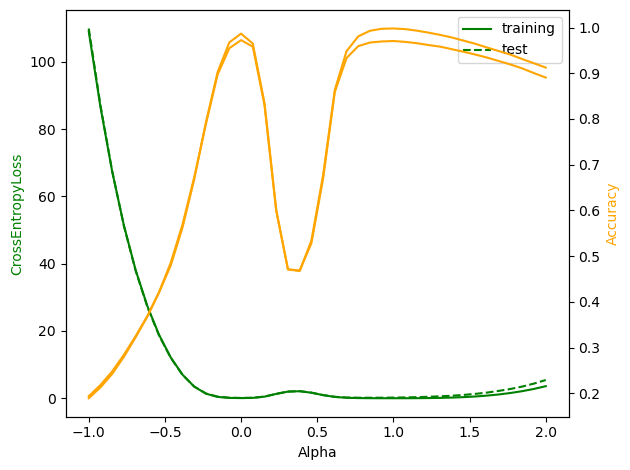

In [28]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Alpha')
ax1.set_ylabel('CrossEntropyLoss', color='green')
ax1.plot(alpha_list, train_loss_list_alpha_lr, color='green', label="training")
ax1.plot(alpha_list, test_loss_list_alpha_lr, '--', color='green', label="test")
ax1.legend()
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy', color='orange')
ax2.plot(alpha_list, train_acc_list_alpha_lr, color='orange', label="sensitivity")
ax2.plot(alpha_list, test_acc_list_alpha_lr, color='orange', label="sensitivity")
fig.tight_layout()

plt.show()